# Задача 3. Реализация обхода в ширину из нескольких стартовых вершин (Multiple-Source BFS)

In [1]:
!pip install python-graphblas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.0/353.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.4/18.4 MB 25.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring

# Задача 1

In [71]:
def MSBFS_Levels(M, s):
  n = M.nrows
  result_1 = Matrix(dtypes.INT32, len(s), n)
  f_1 = Matrix(bool, len(s), n)
  for i in range(len(s)):
    f_1[i, s[i]] << True
  level = 0
  for level in range(n-1):
    result_1(mask=f_1.V) << level
    level += 1
    f_1_before = f_1.dup()

    f_1(~result_1.S, replace=True) << f_1.mxm(M, semiring.lor_land)
    if f_1.isequal(f_1_before):
      break
  pairs = []

  for i in range(result_1.shape[0]):
      result_app = result_1[i, :]
      pairs.append([s[i], result_app.to_dense(fill_value=-1).tolist()])
  return pairs

#Тесты (2 шт)

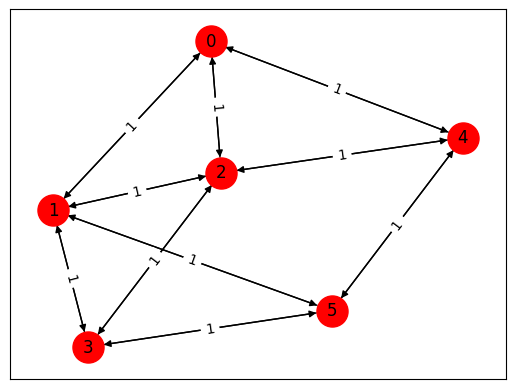

In [72]:
adjacency_matrix = np.array([
    [0, 1, 1, 0, 1, 0],
    [1, 0, 1, 1, 0, 1],
    [1, 1, 0, 1, 1, 0],
    [0, 1, 1, 0, 0, 1],
    [1, 0, 1, 0, 0, 1],
    [0, 1, 0, 1, 1, 0]
])
A = Matrix.from_dense(adjacency_matrix, dtype=dtypes.INT64)
gb.viz.draw(A.dup(mask=A.dup(dtype=dtypes.BOOL)))

In [73]:
s = [1,5] #стартовые вершины
MSBFS_Levels(A,s)

[[1, [1, 0, 1, 1, 2, 1]], [5, [2, 1, 2, 1, 1, 0]]]

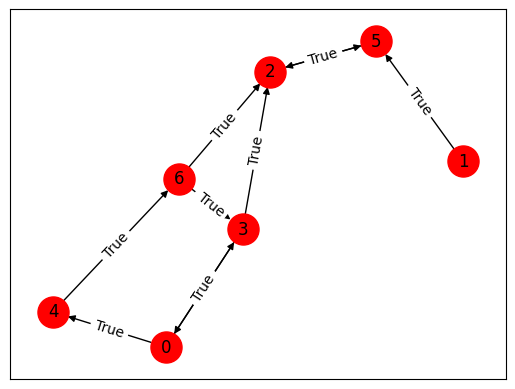

In [74]:
# Недостижимая вершина 1
edges = [
    [3, 0, 3, 5, 6, 0, 6, 2, 1, 4],
    [0, 4, 2, 2, 2, 3, 3, 5, 5, 6],
]
B = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])
gb.viz.draw(B.dup(mask=B.dup(dtype=dtypes.BOOL)))

In [75]:
s = [0,4,5]
MSBFS_Levels(B,s)

[[0, [0, -1, 2, 1, 1, 3, 2]],
 [4, [3, -1, 2, 2, 0, 3, 1]],
 [5, [-1, -1, 1, -1, -1, 0, -1]]]

# Задача 2

In [76]:
def MSBFS_Parents(A, s):
    N = A.nrows
    index_ramp = Matrix(dtypes.UINT64, len(s), N)
    parents = Matrix(dtypes.UINT64, len(s), N)
    row_indices = []
    col_indices = []
    values = []
    for i in range(len(s)):
        for j in range(N):
            row_indices.append(i)
            col_indices.append(j)
            values.append(j)
    index_ramp.build(row_indices, col_indices, values)
    for i in range(len(s)):
        parents[i, s[i]] << N + 1
    wavefront = Matrix(dtypes.UINT64, len(s), N)
    for i in range(len(s)):
        wavefront[i, s[i]] << 0

    while wavefront.nvals > 0:
        wavefront << index_ramp.ewise_mult(wavefront, binary.first)
        wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.min_first)
        parents(binary.plus) << wavefront

    pairs = []
    for i in range(parents.shape[0]):
        parents_app = parents[i, :]
        pairs.append([s[i], [(-1 if val > N else int(val)) for val in parents_app.to_dense(fill_value=-2).tolist()]])

    return pairs


# Тесты (2 шт)

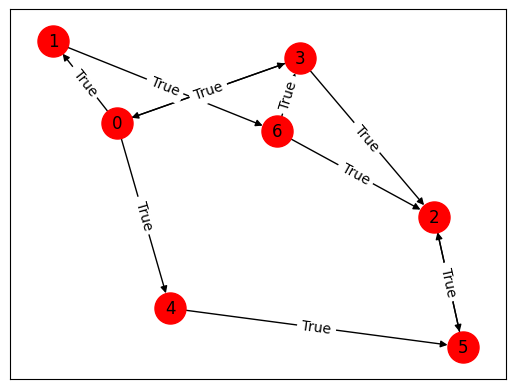

In [77]:
edges = [
    [3, 0, 3, 5, 6, 0, 6, 2, 4, 1, 0],
    [0, 1, 2, 2, 2, 3, 3, 5, 5, 6, 4],
]
R = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])
gb.viz.draw(R.dup(mask=R.dup(dtype=dtypes.BOOL)))

In [78]:
s = [0,4,6]
MSBFS_Parents(R,s)

[[0, [-1, 0, 3, 0, 0, 4, 1]],
 [4, [-2, -2, 5, -2, -1, 4, -2]],
 [6, [3, 0, 6, 6, 0, 2, -1]]]

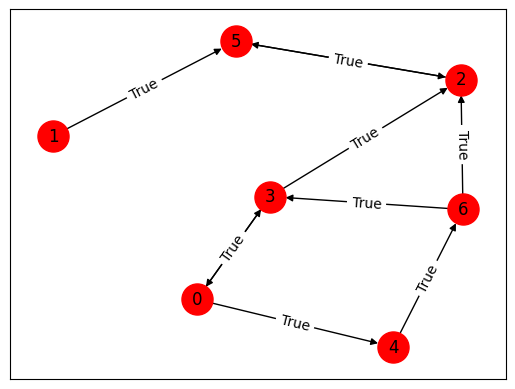

In [79]:
# Недостижимая вершина 1
edges = [
    [3, 0, 3, 5, 6, 0, 6, 2, 1, 4],
    [0, 4, 2, 2, 2, 3, 3, 5, 5, 6],
]
B = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])
gb.viz.draw(B.dup(mask=B.dup(dtype=dtypes.BOOL)))

In [80]:
s = [0,4,6]
MSBFS_Parents(B,s)

[[0, [-1, -2, 3, 0, 0, 2, 4]],
 [4, [3, -2, 6, 6, -1, 2, 4]],
 [6, [3, -2, 6, 6, 0, 2, -1]]]